# Proyecto final

**Procesamiento de Lenguaje Natural** -Maestría en Ciencia de Datos -
Universidad de Sonora


*   Estephania Pivac Alcaraz
*   Victor Manuel Minjares Neriz



## Librerias y descargas

In [2]:
!pip install gdown

In [3]:
# Cargamos las librerías
import pandas as pd
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# Preprocesamiento
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split

# Métricas
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, f1_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve


nltk.download('punkt', force=True)
nltk.download('stopwords')
nltk.download('punkt_tab')
RANDOM_SEED = 16

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# Descargamos el archivo
file_url = 'https://drive.google.com/uc?id=1Kve4q1mpp-EYxAOfKO3lwUAwpYon7_s_'
output = 'final-train.csv'
gdown.download(file_url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Kve4q1mpp-EYxAOfKO3lwUAwpYon7_s_
From (redirected): https://drive.google.com/uc?id=1Kve4q1mpp-EYxAOfKO3lwUAwpYon7_s_&confirm=t&uuid=5cfa55de-8ca5-482f-b5ec-24810bc67345
To: /content/final-train.csv
100%|██████████| 199M/199M [00:02<00:00, 89.8MB/s]


'final-train.csv'

## Preprocesamiento

En el análisis exploratorio de los datos, nos dimos cuenta del gran desequilibrio en el conjunto de datos: la mayoría de las reseñas son positivas, mientras que solo el 14% son negativas. Además, limpiamos los datos eliminando registros duplicados y combinamos las columnas `Summary` y `Text` para tener una única columna, conservando toda la información.

En cuanto a la limpieza enfocada en PLN, eliminamos "stopwords", caracteres no alfanuméricos, espacios en blanco múltiples y tokenizamos. En particular todo lo que este dentro de "<>", que son etiquetas de html que no nos interesan. Este es un procedimiento común en esta área. Por último, como se nos indicó en la descripción del proyecto, convertimos las reseñas con puntuaciones de 1 a 5 en una clasificación binaria, donde 1 representa las reseñas negativas y 0 las positivas.

No se aplicaron lematización ni "stemming" para evitar la pérdida de información relevante para nuestros modelos y también para reducir el tiempo de cómputo.

In [5]:
dataset = pd.read_csv('final-train.csv') # , nrows=100_000
dataset.head()

,Summary,Text,Score
0,Can really notice when I am not drinking it,I have had hormone problems in the past couple...,5
1,"Okay, just not the best",This is a decent balsamic glaze/reducation.<br...,4
2,"goo source of fiber, not so much a source of c...",the cookie is moist and chewy and has a great ...,3
3,Great GF Staple,I have a 4 yr old and a 2 yr old that can't ea...,5
4,Coffee just doesn't taste right without Sweet ...,We have drunk our coffee for 45 years using th...,5


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426340 entries, 0 to 426339
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Summary  426323 non-null  object
 1   Text     426340 non-null  object
 2   Score    426340 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.8+ MB


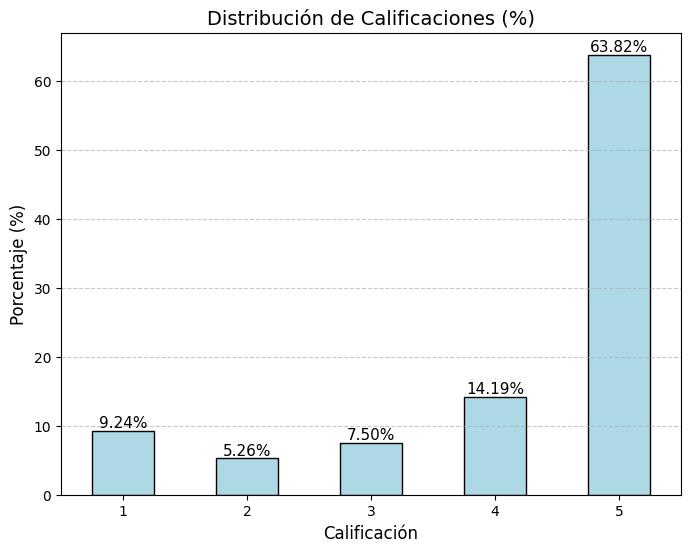

In [10]:
# Calculamos la distribución de calificaciones en porcentaje
score_distribution = dataset['Score'].value_counts(normalize=True) * 100


plt.figure(figsize=(8, 6))
score_distribution.sort_index().plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Distribución de Calificaciones (%)', fontsize=14)
plt.xlabel('Calificación', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xticks(rotation=0)

for index, value in enumerate(score_distribution.sort_index()):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center', fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
missing_values = dataset.isnull().sum()
print(f"\nValores nulos por columna:\n{missing_values}")


Valores nulos por columna:
Summary    17
Text        0
Score       0
dtype: int64


In [12]:
dataset.loc[dataset['Summary'].isnull()]

,Summary,Text,Score
44610,NaN,I only used two maybe three tea bags and got p...,2
101316,NaN,I only used two maybe three tea bags and got p...,2
106173,NaN,I only used two maybe three tea bags and got p...,2
117963,NaN,I only used two maybe three tea bags and got p...,2
121598,NaN,I only used two maybe three tea bags and got p...,2
136690,NaN,I only used two maybe three tea bags and got p...,2
139568,NaN,I only used two maybe three tea bags and got p...,2
145769,NaN,I only used two maybe three tea bags and got p...,2
168120,NaN,I only used two maybe three tea bags and got p...,2
171585,NaN,I like the product and tried it before I pucha...,3


In [13]:
dataset[dataset.duplicated()]

,Summary,Text,Score
1191,"ZiwiPeak is made in the US, consistency problems",Many people are buying this food believing it ...,1
1201,I love this !,I almst hate to say how much this differs from...,5
1218,Great Price for Healthy Cat Food,"I'd give it 5 stars, however the cats don't se...",4
1422,My dog loves these!,Was a great deal when I first bought it for $5...,4
1710,Great coffee!,This is always my first cup of coffee for the ...,5
...,...,...,...
426329,Jack Link's peppered beef jerky,I like the sweetness taste of the Jack Link's ...,4
426330,small & delicious,My Mom & I were itchin for a late-nite snack w...,5
426333,good item :0,This is a good item. My dogs love it. Cut up...,5
426338,Earl Grey of Earl Grey +++,I already liked regular Stash Earl Grey and so...,5


In [14]:
dataset = dataset.drop_duplicates().reset_index(drop=True)

In [15]:
dataset[dataset.duplicated()]

,Summary,Text,Score


In [16]:
dataset

,Summary,Text,Score
0,Can really notice when I am not drinking it,I have had hormone problems in the past couple...,5
1,"Okay, just not the best",This is a decent balsamic glaze/reducation.<br...,4
2,"goo source of fiber, not so much a source of c...",the cookie is moist and chewy and has a great ...,3
3,Great GF Staple,I have a 4 yr old and a 2 yr old that can't ea...,5
4,Coffee just doesn't taste right without Sweet ...,We have drunk our coffee for 45 years using th...,5
...,...,...,...
309112,Ahhh.... Very good for afternoon break,I am now enjoying my first cup of this tea; th...,5
309113,Good Tasting,This tomato paste makes an excellent spaghetti...,5
309114,funnel cake mix,This is very good and just like the gourmet on...,4
309115,Yummy Fruit Snacks,I bought these for my kids but find myself eat...,5


In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309117 entries, 0 to 309116
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Summary  309115 non-null  object
 1   Text     309117 non-null  object
 2   Score    309117 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 7.1+ MB


In [18]:
dataset.loc[dataset['Summary'].isnull()]

,Summary,Text,Score
41580,NaN,I only used two maybe three tea bags and got p...,2
141441,NaN,I like the product and tried it before I pucha...,3


In [19]:
# Concatenar columnas de texto
dataset.loc[:,'Concat_text'] = np.where(dataset['Summary'].isnull(),
                                        dataset['Text'],
                                        dataset['Summary'] + '. ' + dataset['Text'])
dataset = dataset.drop(['Summary', 'Text'], axis=1)

In [20]:
# Vemos ejemplos de los dos casos de concatenación
print(dataset.iloc[41580])
print(dataset.iloc[410])

Score                                                          2
Concat_text    I only used two maybe three tea bags and got p...
Name: 41580, dtype: object
Score                                                          5
Concat_text    Love them!. I love Oat Squares, I'll eat them ...
Name: 410, dtype: object


In [21]:
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = re.sub(r'<.*?>.*?<.*?/>|<.*?>', '', text) # Quitamos html tags y su contenido
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [22]:
start_time = time.time()
dataset['cleaned_text'] = dataset['Concat_text'].map(preprocess_text)
end_time = time.time()
print(f"Execution time: {end_time-start_time:.2f} seconds")

Execution time: 120.05 seconds


In [23]:
dataset.head()

,Score,Concat_text,cleaned_text
0,5,Can really notice when I am not drinking it. I...,really notice drinking hormone problems past c...
1,4,"Okay, just not the best. This is a decent bals...",okay best decent balsamic glaze reducation fai...
2,3,"goo source of fiber, not so much a source of c...",goo source fiber much source chocoate cookie m...
3,5,Great GF Staple. I have a 4 yr old and a 2 yr ...,great gf staple 4 yr old 2 yr old eat gluten a...
4,5,Coffee just doesn't taste right without Sweet ...,coffee taste right without sweet n low drunk c...


In [24]:
# Dividir en conjunto de entrenamiento y prueba
X = dataset['cleaned_text']
y = dataset['Score'].apply(lambda x: 1 if x in [1, 2] else 0)  # Etiqueta binaria

In [25]:
y.value_counts()[1]

45134

In [26]:
proportion_neg = y.value_counts()[1]/(y.value_counts()[0] + y.value_counts()[1])
proportion_neg

0.14600943979140585

## Modelos de análisis de sentimiento

### Modelo de Naive Bayes con Vectorización TF-IDF

El primer modelo que analizaremos es Naive Bayes con vectorización TF-IDF. Elegimos este modelo junto con esta técnica de vectorización debido al sorprendente rendimiento que demostró a lo largo del curso en diferentes tareas. Ahora veremos si en esta tarea de análisis de sentimiento logra mantener ese desempeño.

Para la obtención de los hiperparámetros `max_features` y `class_prior`, utilizamos la experimentación, considerando tanto la métrica `balanced_accuracy` como el tiempo de cómputo. En este modelo, al igual que en los siguientes, estratificamos los datos al momento de dividirlos, debido al notable desequilibrio en las clases. Escogimos la métrica `balanced_accuracy` como principal, ya que está diseñada específicamente para casos con clases desbalanceadas. Otra métrica buena obtenida es la curva ROC, la cual nos dice que nuestro modelo es un buen clasificador.

Al finalizar nuestras pruebas, en el tiempo disponible, obtuvimos resultados satisfactorios, especialmente al considerar la rapidez y la simplicidad del modelo, características que también se observaron en otros ejercicios previos.

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [66]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


nb_model = MultinomialNB(class_prior=[0.45, 0.55])
nb_model.fit(X_train_tfidf, y_train)


y_pred_nb = nb_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_nb))

balanced_acc = balanced_accuracy_score(y_test, y_pred_nb)
print(f'Balanced Accuracy: {balanced_acc:.2f}')

              precision    recall  f1-score   support

           0       0.98      0.81      0.89     52797
           1       0.45      0.90      0.60      9027

    accuracy                           0.82     61824
   macro avg       0.71      0.86      0.74     61824
weighted avg       0.90      0.82      0.85     61824

Balanced Accuracy: 0.86


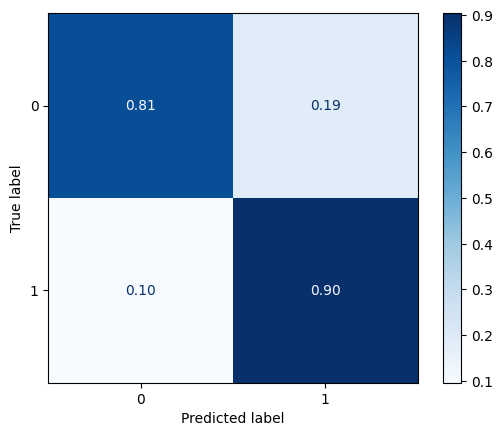

In [67]:
cm_normalized = confusion_matrix(y_test, y_pred_nb, normalize='true')
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=nb_model.classes_)
disp_normalized.plot(cmap="Blues", values_format=".2f")

ROC-AUC: 0.93


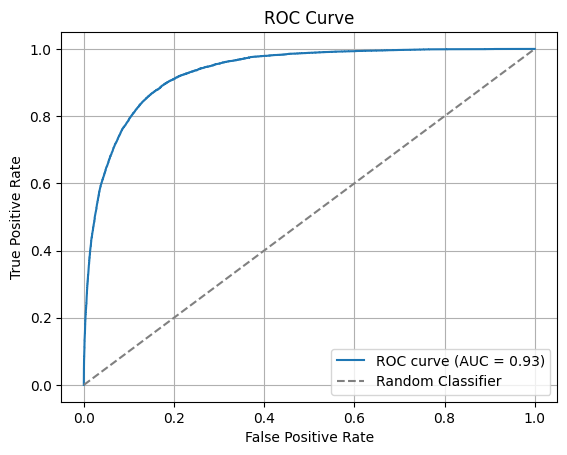

In [68]:
if len(nb_model.classes_) == 2:
    y_prob = nb_model.predict_proba(X_test_tfidf)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    print(f'ROC-AUC: {auc:.2f}')

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Classifier")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

### DistilBERT

Un modelo adicional que seleccionamos fue DistilBERT, el cual es una versión ligera de BERT. Esta herramienta es más eficiente en términos computacionales ya que consume aproximadamente un 40% menos de recursos y es un 60% más rápido que BERT, por lo que pensamos que es ideal nuestros recursos limitados en Google Colab.

Otro atributo de este modelo es que mantiene un rendimiento competitivo en tareas de clasificación de texto, lo que garantiza buenos resultados para el análisis de sentimientos y fue entrenado en un corpus muy amplio con contextos variados por lo que creemos que lo hace un buen candidato para la tarea de clasificación

Para la configuración utilizamos num_labels=2 lo que indica una clasificación binaria (positivo o negativo), adaptándose al problema de análisis de sentimientos en cuestión.

In [28]:
!pip install transformers datasets torch

In [29]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
# Preparamos el conjunto de datos y balanceamos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

df_train = pd.DataFrame({"text": X_train, "label": y_train})
# Tomamos una submuestra balanceada de 3000 elementos
n_samples_train = 3000
df_train_balanced = df_train.groupby("label").sample(n=n_samples_train, random_state=42)

# Dividimos el conjunto de entrenamiento balanceado
X_train_balanced = df_train_balanced["text"].tolist()
y_train_balanced = df_train_balanced["label"].tolist()
X_subsample, X_eval, y_subsample, y_eval = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.5, random_state=RANDOM_SEED, stratify=y_train_balanced
)


In [49]:
# Tokenizador
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenización de los conjuntos de datos
train_encodings = tokenizer(list(X_subsample), truncation=True, padding=True, max_length=128, return_tensors="pt")
eval_encodings = tokenizer(list(X_eval), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128, return_tensors="pt")


In [51]:
# Convertir etiquetas a tensores
train_labels = torch.tensor(y_subsample)
eval_labels = torch.tensor(y_eval)
test_labels = torch.tensor(y_test.tolist())

# Crear un dataset personalizado
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
eval_dataset = SentimentDataset(eval_encodings, eval_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [52]:
# Modelo preentrenado
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Configurar entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Función de métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)

    # Calcular métricas adicionales
    acc = accuracy_score(labels, predictions)
    bal_acc = balanced_accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")

    # Mostrar matriz de confusión
    conf_matrix = confusion_matrix(labels, predictions)
    print("Matriz de Confusión:\n", conf_matrix)

    return {
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Entrenar modelo
trainer.train()

# Evaluar modelo
metrics = trainer.evaluate()
print(metrics)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,Precision,Recall,F1
1,0.398500,0.369386,0.849000,0.849000,0.851107,0.846000,0.848546
2,0.321100,0.428723,0.814333,0.814333,0.906816,0.700667,0.790523
3,0.198400,0.510506,0.852333,0.852333,0.864734,0.835333,0.849780
4,0.209200,0.709780,0.844333,0.844333,0.888638,0.787333,0.834924
5,0.105100,0.718234,0.852333,0.852333,0.850697,0.854667,0.852677


Matriz de Confusión:
 [[1278  222]
 [ 231 1269]]
Matriz de Confusión:
 [[1392  108]
 [ 449 1051]]
Matriz de Confusión:
 [[1304  196]
 [ 247 1253]]
Matriz de Confusión:
 [[1352  148]
 [ 319 1181]]
Matriz de Confusión:
 [[1275  225]
 [ 218 1282]]


Matriz de Confusión:
 [[1278  222]
 [ 231 1269]]
{'eval_loss': 0.3693864047527313, 'eval_accuracy': 0.849, 'eval_balanced_accuracy': 0.849, 'eval_precision': 0.8511066398390342, 'eval_recall': 0.846, 'eval_f1': 0.8485456369107321, 'eval_runtime': 11.3092, 'eval_samples_per_second': 265.271, 'eval_steps_per_second': 16.624, 'epoch': 5.0}


Hiperparámetros utilizados.

**Número de épocas (num_train_epochs=5):** Se optó por 5 épocas para equilibrar el tiempo de entrenamiento y el riesgo de sobreajuste. En modelos preentrenados como DistilBERT, suelen ser suficientes para ajustar el modelo a la tarea específica sin perder la generalización.


**Tamaño de batch (per_device_train_batch_size=16):** Un tamaño de lote pequeño se utiliza debido a las limitaciones de memoria de GPU. También mejora la regularización al introducir más ruido en el gradiente, lo que puede evitar el sobreajuste.


**Warmup steps (warmup_steps=500):** Los pasos de calentamiento ayudan a estabilizar el entrenamiento al comienzo, permitiendo que el modelo se ajuste gradualmente a los datos específicos.


**Decay de pesos (weight_decay=0.01):**
Se introduce para regularizar el modelo y prevenir el sobreajuste, penalizando grandes valores en los pesos.

**Estrategias de evaluación y guardado (evaluation_strategy="epoch", save_strategy="epoch"):** El modelo se evalúa al final de cada época y guarda el mejor modelo automáticamente, asegurando que siempre se conserve la versión con el mejor desempeño en el conjunto de validación.

In [55]:
# Guardar el modelo y el tokenizador en una carpeta
model.save_pretrained("modelo_DistilBert")
tokenizer.save_pretrained("modelo_DistilBert")

('modelo_DistilBert/tokenizer_config.json',
 'modelo_DistilBert/special_tokens_map.json',
 'modelo_DistilBert/vocab.txt',
 'modelo_DistilBert/added_tokens.json')

In [53]:
from sklearn.metrics import classification_report

# Predicciones del modelo
predictions_output = trainer.predict(test_dataset)
logits = predictions_output.predictions
labels = predictions_output.label_ids

# Convertir logits a predicciones y etiquetas reales
predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()

# Reporte de clasificación
print("\nReporte de Clasificación:\n")
print(classification_report(labels, predictions, digits=2))

# Balanced Accuracy
print("\nBalanced Accuracy:\n")
print(balanced_accuracy_score(labels, predictions))

Matriz de Confusión:
 [[44991  7806]
 [ 1278  7749]]

Reporte de Clasificación:

              precision    recall  f1-score   support

           0       0.97      0.85      0.91     52797
           1       0.50      0.86      0.63      9027

    accuracy                           0.85     61824
   macro avg       0.74      0.86      0.77     61824
weighted avg       0.90      0.85      0.87     61824


Balanced Accuracy:

0.8552877081013338


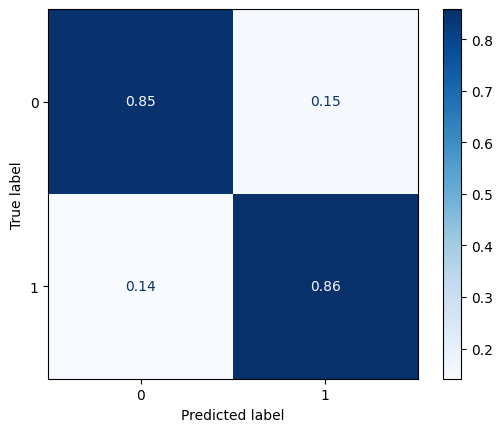

In [54]:
# Calcular matriz de confusión
conf_matrix_normalized = confusion_matrix(labels, predictions, normalize='true')

disp_normalized = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=[0, 1])
disp_normalized.plot(cmap="Blues", values_format=".2f")

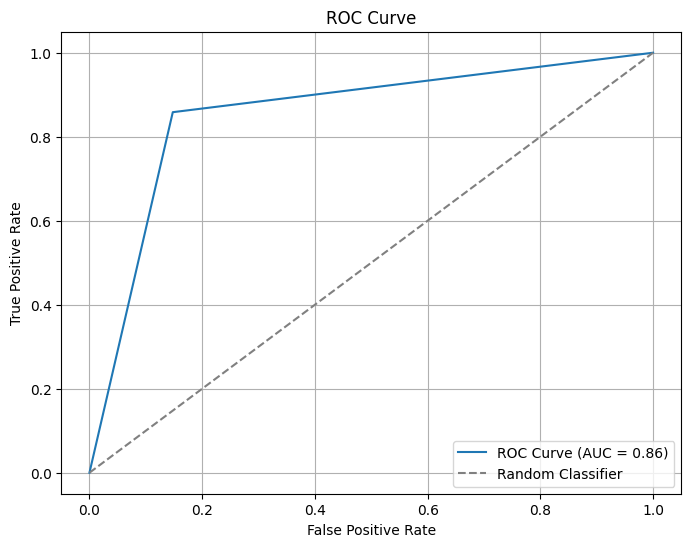

In [56]:
fpr, tpr, _ = roc_curve(labels, predictions)
roc_auc = roc_auc_score(labels, predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### VADER

Otra opción que exploramos fue VADER (Valence Aware Dictionary and sEntiment Reasoner), una herramienta de análisis de sentimientos basada en reglas y léxico. Esta herramienta fue entrenada para analizar sentimientos en mensajes de redes sociales, es decir, en lenguaje coloquial e informal (según su repositorio en GitHub, incluso puede reconocer emojis). Esta característica encajaba perfectamente con nuestro caso, ya que las reseñas contienen un lenguaje similar. Sin embargo, los resultados obtenidos no fueron satisfactorios y fueron inferiores a los de los modelos previos.

Realizamos pruebas utilizando tanto el conjunto de datos sin limpiar como el conjunto limpiado, con diferentes valores de "compound" (una variable que indica qué tan negativo o positivo es el sentimiento, donde -1 es extremadamente negativo y +1 es extremadamente positivo). También consideramos diversas métricas como `balanced_accuracy`, `f1 score`, `sensitivity` y `negative predictive value`. Las primeras métricas se enfocan en conjuntos de datos desbalanceados, mientras que las segundas priorizan identificar la mayor cantidad de verdaderos negativos, ya que este era un requisito de la tarea. Al final obtuvimos los mejores resultados con los datos sin limpiar y tomando en cuenta la métrica `balanced_accuracy`.

Aunque este modelo está diseñado específicamente para este tipo de datos, los resultados obtenidos con nuestro sencillo modelo de Naive Bayes con vectorización TF-IDF fueron superiores.

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
# VADER
analyzer = SentimentIntensityAnalyzer()

# Polaridad de sentimiento de una oración
def get_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score['compound']  # Métrica "compound" va de -1 a 1

In [ ]:
# Preparamos conjuntos de datos
X = dataset['Concat_text']
y = dataset['Score'].apply(lambda x: 1 if x in [1, 2] else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

X_sentiment_train = X_train.apply(get_sentiment)
X_sentiment_test = X_test.apply(get_sentiment)

In [ ]:
# Ajuste fino del umbral
def fine_tune_threshold(X_sentiment, y, thresholds):
    best_threshold = None
    best_metric = 0

    for threshold in thresholds:
        # Convertimos "compound" a nuestras etiquetas
        y_pred = X_sentiment.apply(lambda score: 0 if score >= threshold else 1)

        # Métrica
        cm = confusion_matrix(y, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        sensitivity = tp / (tp + fn)
        balanced_acc = (sensitivity + specificity)/2

        if balanced_acc > best_metric:
            best_metric = balanced_acc
            best_threshold = threshold

    return best_threshold, best_metric

In [ ]:
thresholds = np.linspace(-1, 1, 100)
best_threshold, best_metric = fine_tune_threshold(X_sentiment_train, y_train, thresholds)
print(f"Mejor umbral: {best_threshold}")
print(f"Mejor métrica: {best_metric}")

y_pred = X_sentiment_test.apply(lambda score: 0 if score >= best_threshold else 1)
print(classification_report(y_test, y_pred))

Mejor umbral: 0.7171717171717173
Mejor métrica: 0.7810692825239358
              precision    recall  f1-score   support

           0       0.95      0.83      0.88     52797
           1       0.42      0.74      0.54      9027

    accuracy                           0.81     61824
   macro avg       0.69      0.78      0.71     61824
weighted avg       0.87      0.81      0.83     61824



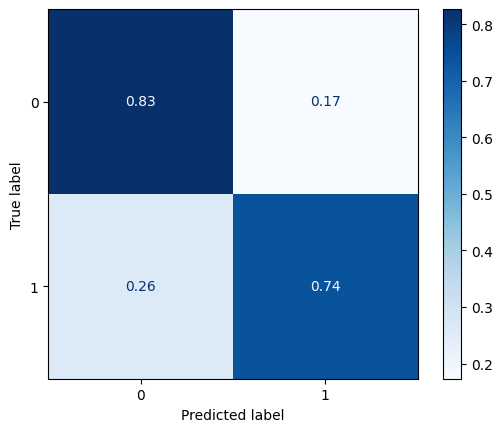

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[0, 1])
disp_normalized.plot(cmap="Blues", values_format=".2f")

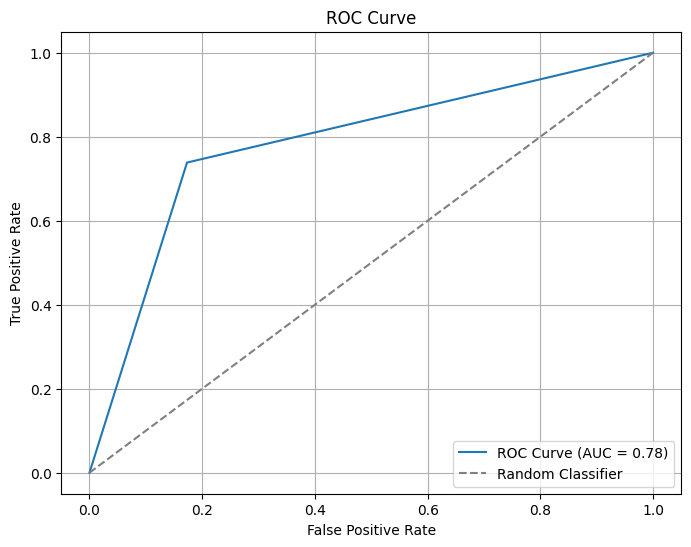

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Análisis de tópicos

Para la obtención de tópicos exploramos varios métodos, como LDA (Latent Dirichlet Allocation) con vectorización por conteo de palabras y TF-IDF, NMF (Non-negative Matrix Factorization), y finalmente un modelo LLM como BERTopic. La elección de estos modelos se basó en la comparación de enfoques: LDA, visto en clases, es un modelo probabilístico, mientras que NMF es un modelo no probabilístico. Por último, BERTopic es un modelo LLM entrenado específicamente para la detección de tópicos.

Un comportamiento curioso de BERTopic es el número de grupos que genera cuando no se especifica previamente el número deseado; en este caso, produjo alrededor de 100 tópicos. Sin embargo, muchos de estos no ofrecían información significativa, al menos entre los que pudimos revisar.

Tras explorar los modelos, experimentar con ellos y compararlos, logramos identificar cinco productos o situaciones que generan la mayor cantidad de reseñas negativas:

1. Café
2. Té
3. Entregas
4. China
5. Chocolate

A continuación, presentamos algunos ejemplos de los tópicos generados por los diferentes modelos:

* LDA con Bag of Words:

    Tópico 0: ['would', 'one', 'beans', 'good', 'flavor', 'cups', 'taste', 'like', 'cup', 'coffee'] (Café)

    Tópico 2: ['sugar', 'really', 'would', 'one', 'cookies', 'flavor', 'good', 'chocolate', 'like', 'taste'] (Chocolate)

    Tópico 3: ['would', 'one', 'tastes', 'good', 'drink', 'water', 'flavor', 'like', 'taste', 'tea'] (Té)

    Tópico 5: ['bag', 'received', 'time', 'would', 'one', 'ordered', 'box', 'order', 'amazon', 'product'] (Entregas)

    Tópico 6: ['one', 'item', 'would', 'box', 'store', 'get', 'buy', 'amazon', 'product', 'price'] (Entregas)

* LDA con TF-IDF:

    Tópico 0: ['bitter', 'beans', 'good', 'weak', 'flavor', 'like', 'taste', 'cups', 'cup', 'coffee'] (Café)

    Tópico 1: ['one', 'ingredients', 'item', 'china', 'dog', 'buy', 'price', 'amazon', 'food', 'product'] (China)

    Tópico 3: ['sugar', 'one', 'good', 'tastes', 'drink', 'water', 'flavor', 'like', 'taste', 'tea'] (Té)

* NMF:

    Tópico 1: ['flavor', 'pods', 'beans', 'bitter', 'roast', 'instant', 'weak', 'cups', 'cup', 'coffee'] (Café)

    Tópico 2: ['drink', 'chai', 'black', 'weak', 'flavor', 'cup', 'bags',   'teas', 'green', 'tea'] (Té)

    Tópico 3: ['one', 'item', 'received', 'buy', 'ordered', 'order', 'price', 'box', 'amazon', 'product'] (Entregas)

    Tópico 4: ['chicken', 'made', 'cats', 'china', 'eat', 'treats', 'cat', 'dogs', 'food', 'dog'] (China)

    Tópico 5: ['white', 'cocoa', 'milk', 'cookie', 'bar', 'dark', 'bars', 'hot', 'cookies', 'chocolate'] (Chocolate)

* BERTopic:

    Tópico 0: ['product', 'amazon', 'box', 'price', 'order', 'received', 'item', 'ordered', 'would', 'one'] (Entregas)

    Tópico 1: ['taste', 'like', 'chocolate', 'flavor', 'product', 'good', 'one', 'would', 'cereal', 'eat'] (Chocolate)

    Tópico 3: ['coffee', 'cup', 'cups', 'like', 'taste', 'flavor', 'beans', 'good', 'roast', 'one'] (Café)

    Tópico 5: ['dog', 'dogs', 'food', 'treats', 'china', 'made', 'product', 'treat', 'chicken', 'one'] (China)


Un tópico que nos llamó la atención fue el de "China". Observamos que muchas reseñas negativas estaban relacionadas con productos provenientes de ese país. Algunas reseñas mencionaban que les gustaban los productos hasta que descubrían que eran de China. Otra observación interesante fue la asociación entre "perro" y "China". Inicialmente pensamos que podría deberse al estereotipo de que los chinos comen perros, pero en realidad, esto se debía a que muchos productos son alimentos para perros o porque los dueños mencionaban que planeaban dárselos a sus perros debido a su origen de China.

In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00


In [ ]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.6 MB/s eta 0:00:00


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV
import pyLDAvis

In [ ]:
# Filtrar reviews negativas
negative_reviews = dataset[dataset['Score'].isin([1, 2])]['cleaned_text']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LDA (Latent Dirichlet Allocation)

In [ ]:
count_vectorizer = CountVectorizer(max_features=5000)
X_neg_counts = count_vectorizer.fit_transform(negative_reviews)

# Entrenamiento
lda_search_params = {'n_components': [3, 5, 7]}
lda = LatentDirichletAllocation(random_state=RANDOM_SEED)
lda_grid_search = GridSearchCV(lda, param_grid=lda_search_params, cv=2)
lda_grid_search.fit(X_neg_counts)

best_lda_n_topics = lda_grid_search.best_params_['n_components']
print(f"Mejores tópicos LDA: {best_lda_n_topics}")

lda_best = LatentDirichletAllocation(n_components=best_lda_n_topics, random_state=RANDOM_SEED)
lda_best.fit(X_neg_counts)

for idx, topic in enumerate(lda_best.components_):
    print(f"Tópico {idx}: {[count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Mejores tópicos LDA: 7
Tópico 0: ['would', 'one', 'beans', 'good', 'flavor', 'cups', 'taste', 'like', 'cup', 'coffee']
Tópico 1: ['organic', 'corn', 'products', 'cat', 'oil', 'dog', 'made', 'ingredients', 'product', 'food']
Tópico 2: ['sugar', 'really', 'would', 'one', 'cookies', 'flavor', 'good', 'chocolate', 'like', 'taste']
Tópico 3: ['would', 'one', 'tastes', 'good', 'drink', 'water', 'flavor', 'like', 'taste', 'tea']
Tópico 4: ['food', 'product', 'even', 'good', 'eat', 'taste', 'dog', 'would', 'one', 'like']
Tópico 5: ['bag', 'received', 'time', 'would', 'one', 'ordered', 'box', 'order', 'amazon', 'product']
Tópico 6: ['one', 'item', 'would', 'box', 'store', 'get', 'buy', 'amazon', 'product', 'price']


In [ ]:
tfidf_neg = TfidfVectorizer(max_features=5000)
X_neg_tfidf = tfidf_neg.fit_transform(negative_reviews)

lda = LatentDirichletAllocation(n_components=7, random_state=RANDOM_SEED)
lda.fit(X_neg_tfidf)

for idx, topic in enumerate(lda.components_):
    print(f"Tópico {idx}: {[tfidf_neg.get_feature_names_out()[i] for i in topic.argsort()[-10:]]}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Tópico 0: ['bad', 'really', 'product', 'one', 'would', 'chocolate', 'good', 'flavor', 'like', 'taste']
Tópico 1: ['like', 'ingredients', 'popcorn', 'soup', 'oil', 'salt', 'cats', 'cat', 'product', 'food']
Tópico 2: ['juice', 'butter', 'flavor', 'syrup', 'sweet', 'ingredients', 'product', 'like', 'taste', 'sugar']
Tópico 3: ['product', 'good', 'green', 'one', 'water', 'drink', 'flavor', 'taste', 'like', 'tea']
Tópico 4: ['one', 'like', 'jerky', 'eat', 'made', 'china', 'food', 'treats', 'dogs', 'dog']
Tópico 5: ['roast', 'good', 'bitter', 'weak', 'like', 'flavor', 'taste', 'cups', 'cup', 'coffee']
Tópico 6: ['buy', 'shipping', 'ordered', 'item', 'received', 'order', 'box', 'price', 'product', 'amazon']


In [ ]:
lda_vis = pyLDAvis.prepare(
    topic_term_dists=lda_best.components_,
    doc_topic_dists=lda_best.transform(X_neg_counts),
    doc_lengths=X_neg_counts.sum(axis=1).A1,
    vocab=count_vectorizer.get_feature_names_out(),
    term_frequency=X_neg_counts.sum(axis=0).A1,
)
pyLDAvis.display(lda_vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### NMF (Non-negative Matrix Factorization)

In [ ]:
nmf = NMF(n_components=7, random_state=RANDOM_SEED)
nmf.fit(X_neg_tfidf)

for idx, topic in enumerate(nmf.components_):
    print(f"Tópico {idx}: {[tfidf_neg.get_feature_names_out()[i] for i in topic.argsort()[-10:]]}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Tópico 0: ['one', 'would', 'tried', 'bad', 'really', 'tastes', 'good', 'flavor', 'like', 'taste']
Tópico 1: ['flavor', 'pods', 'beans', 'bitter', 'roast', 'instant', 'weak', 'cups', 'cup', 'coffee']
Tópico 2: ['drink', 'chai', 'black', 'weak', 'flavor', 'cup', 'bags', 'teas', 'green', 'tea']
Tópico 3: ['one', 'item', 'received', 'buy', 'ordered', 'order', 'price', 'box', 'amazon', 'product']
Tópico 4: ['chicken', 'made', 'cats', 'china', 'eat', 'treats', 'cat', 'dogs', 'food', 'dog']
Tópico 5: ['white', 'cocoa', 'milk', 'cookie', 'bar', 'dark', 'bars', 'hot', 'cookies', 'chocolate']
Tópico 6: ['natural', 'ingredient', 'syrup', 'corn', 'gluten', 'sweet', 'ingredients', 'product', 'free', 'sugar']


### BERTopic

In [ ]:
from bertopic import BERTopic
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=10)
topic_model = BERTopic(hdbscan_model=cluster_model)
topics, probs = topic_model.fit_transform(negative_reviews)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
topic_model.visualize_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
all_topics = topic_model.get_topics()
for topic_id, words in all_topics.items():
    top_words = [word for word, score in words[:10]]
    print(f"Tópico {topic_id}: {top_words}")

Tópico 0: ['product', 'amazon', 'box', 'price', 'order', 'received', 'item', 'ordered', 'would', 'one']
Tópico 1: ['taste', 'like', 'chocolate', 'flavor', 'product', 'good', 'one', 'would', 'cereal', 'eat']
Tópico 2: ['like', 'taste', 'salt', 'product', 'sauce', 'flavor', 'good', 'soup', 'would', 'cheese']
Tópico 3: ['coffee', 'cup', 'cups', 'like', 'taste', 'flavor', 'beans', 'good', 'roast', 'one']
Tópico 4: ['water', 'sugar', 'taste', 'like', 'drink', 'product', 'flavor', 'juice', 'syrup', 'one']
Tópico 5: ['dog', 'dogs', 'food', 'treats', 'china', 'made', 'product', 'treat', 'chicken', 'one']
Tópico 6: ['tea', 'green', 'ginger', 'like', 'taste', 'teas', 'flavor', 'good', 'drink', 'bags']
Tópico 7: ['cookies', 'gluten', 'cookie', 'free', 'cake', 'like', 'bread', 'taste', 'mix', 'flour']
Tópico 8: ['seeds', 'plant', 'trap', 'tree', 'traps', 'one', 'work', 'flowers', 'plants', 'product']
Tópico 9: ['cat', 'cats', 'food', 'eat', 'litter', 'one', 'would', 'like', 'even', 'product']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Evaluación de análisis de sentimiento

In [81]:
# Cargamos el conjunto
data_test = pd.read_csv('test.csv')
data_test.head()

,Summary,Text
0,I love Hills!,"My cat is picky, especially when it comes to d..."
1,"Thank you, Amazon!","My mom, who has always believed that breakfast..."
2,"Good product, good price",This is my third container of this drink mix. ...
3,Soooo Good!,The first time I had a cup of this tea was at ...
4,Not as good as Libby's; cans in bad condition,There have been ongoing problems with dented a...


In [82]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7105 entries, 0 to 7104
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Summary  7105 non-null   object
 1   Text     7105 non-null   object
dtypes: object(2)
memory usage: 111.1+ KB


In [83]:
start_time = time.time()
data_test = data_test.drop_duplicates().reset_index(drop=True)
data_test.loc[:,'Concat_text'] = np.where(data_test['Summary'].isnull(),
                                        data_test['Text'],
                                        data_test['Summary'] + '. ' + data_test['Text'])
data_test = data_test.drop(['Summary', 'Text'], axis=1)
data_test['cleaned_text'] = data_test['Concat_text'].map(preprocess_text)
end_time = time.time()
print(f"Execution time: {end_time-start_time:.2f} seconds")

Execution time: 2.59 seconds


### Naive Bayes con TF-IDF

In [84]:
# NB con TF-IDF
data_test_tfidf = tfidf.transform(data_test['cleaned_text'])
y_final_pred_nb = nb_model.predict(data_test_tfidf)
np.savetxt("predicciones_NB_TF-IDF.csv", y_final_pred_nb, delimiter=",", fmt="%d")

### DistilBERT

In [85]:
from torch.utils.data import Dataset

# Preprocesamiento
X_final_test = dataset_test['cleaned_text']
final_test_encodings = tokenizer(list(X_final_test), truncation=True, padding=True, max_length=128, return_tensors="pt")

# Crear un Dataset sin las etiquetas
class CustomDatasetNoLabels(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

# Crear el Dataset para el conjunto de prueba
finaltest_dataset = CustomDatasetNoLabels(final_test_encodings)

In [86]:
# Realizar las predicciones
predictions_output = trainer.predict(finaltest_dataset)

# Extraer los logits
logits = predictions_output.predictions

# Convertir los logits a predicciones (clase final)
predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()


print(predictions[:10])

predictions_df = pd.DataFrame(predictions, columns=["Predicción"])
predictions_df.to_csv("predicciones_DistilBert.csv", index=False)

<ipython-input-85-e904025af9c5>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


[0 0 0 0 1 0 0 0 0 0]


## Conclusiones

El modelo Naive Bayes con TF-IDF demostró ser la mejor opción para la clasificación de reseñas negativas, mientras que LDA y NMF destacaron en la identificación de temas. Aunque herramientas como DistilBERT, VADER y BERTopic tienen aplicaciones prometedoras, no superaron las alternativas seleccionadas.

El análisis de tópicos revela áreas clave de mejora para la empresa, especialmente en productos específicos (café, té, chocolate) y procesos (entregas). Estas observaciones permiten priorizar las acciones para abordar las quejas más comunes y mejorar la experiencia del cliente.
